# CLUSTERING

### Importamos las librerías

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler


### Importamos el dataset y lo limpiamos

In [2]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [3]:
filename = "nasa/event/event_wind_summary/event_wind_summary.csv"
fd = pd.read_csv(filename);
fd = clean_dataset(fd);
fd.columns

Index(['ARCHIVED_RECORD_NUMBER', 'SEISMIC_TIME_SOLS', 'ORIGINAL_FILE_NUMBER',
       'ORIGINAL_RECORD_NUMBER', 'DATA_ACQUISITION_SOL',
       'DATA_ACQUISITION_HOUR', 'DATA_ACQUSITION_MINUTE',
       'DATA_ACQUISITION_SECOND', 'MEDIAN_X_AXIS', 'FIRST_X_AXIS',
       'MAXIMUM_X_AXIS', 'MINIMUM_X_AXIS', 'RMS_X_AXIS_X100',
       'RMS_Y_AXIS_X100', 'RMS_Z_AXIS_X100', 'MEAN_X_AXIS_CROSSINGS',
       'MEAN_Y_AXIS_CROSSINGS', 'MEAN_Z_AXIS_CROSSINGS', 'METEO_TIME_SOLS',
       'WINDSPEED', 'PRESSURE', 'WIND_DIRECTION', 'AIR_TEMPERATURE',
       'WIND_SEISMIC_INTERVAL'],
      dtype='object')

### Normalizamos el dataset completo

In [4]:
#df_norm = ( fd - fd.min()) / ( fd.max() - fd.min() )
df_norm = StandardScaler().fit_transform(fd.astype(float))
df_norm= pd.DataFrame(df_norm, columns=fd.columns)

### Buscamos grupos de variables dependientes

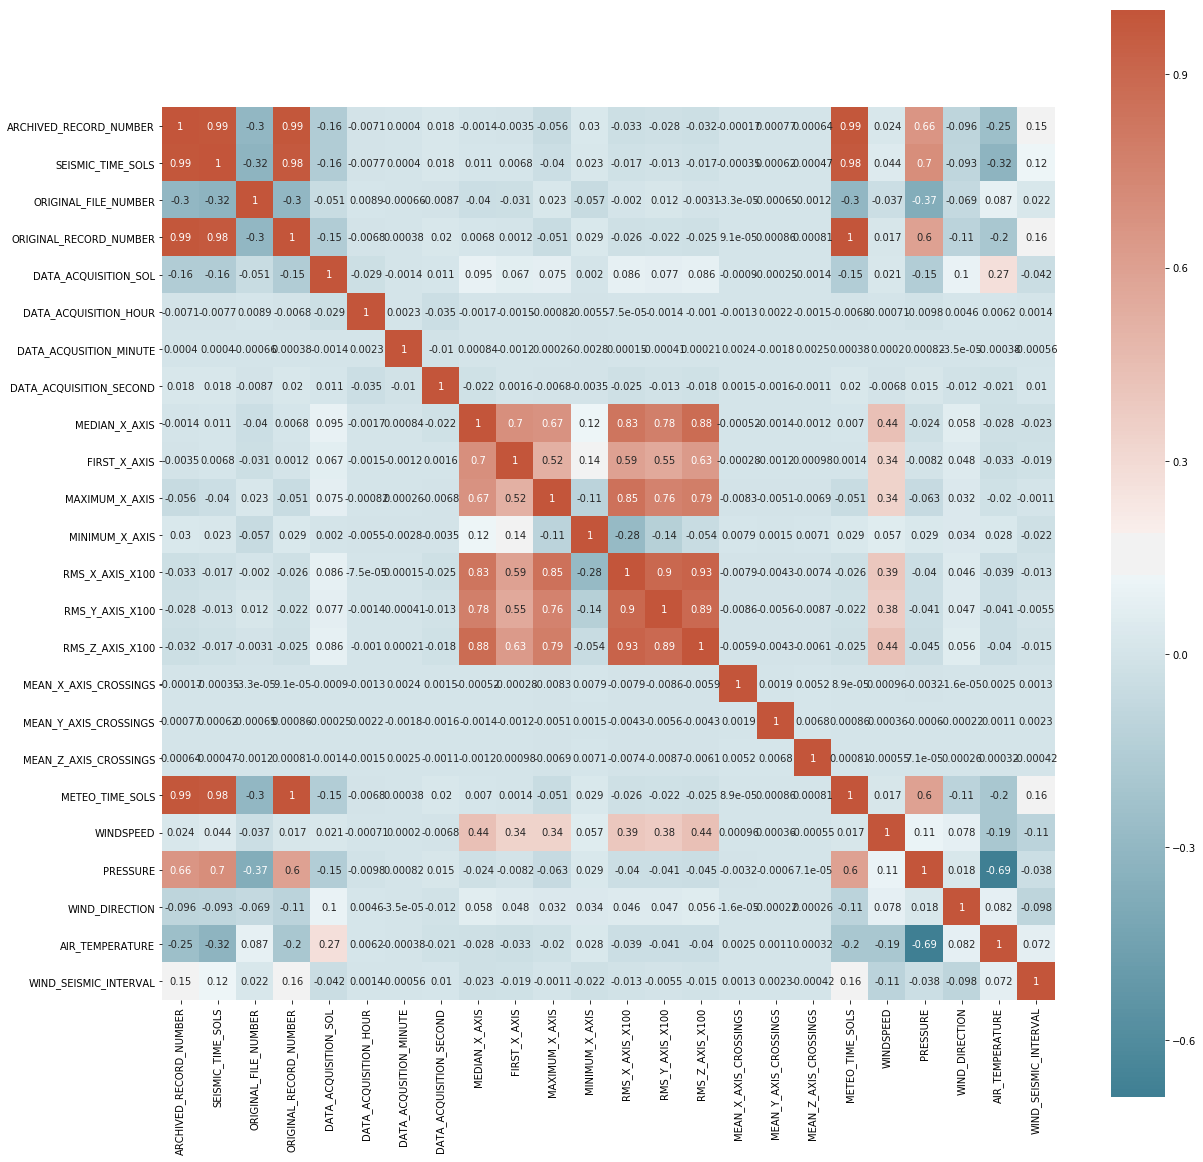

In [5]:
f, ax = plt.subplots(figsize=(20,20)) 
corr = df_norm.corr()
sns.heatmap(corr,square=True ,cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax , annot = True) 

In [6]:
#GRUPO 1 -> 
gp_1 = ['MEDIAN_X_AXIS', 'FIRST_X_AXIS',
       'MAXIMUM_X_AXIS','RMS_X_AXIS_X100',
       'RMS_Y_AXIS_X100', 'RMS_Z_AXIS_X100','WINDSPEED']

#GRUPO 2 -> 
gp_2 = ['PRESSURE','AIR_TEMPERATURE']

#GRUPO 3 ( INDEPENDIENTES ) -> 
gp_3 = ['SEISMIC_TIME_SOLS','MINIMUM_X_AXIS','MEAN_X_AXIS_CROSSINGS',
       'MEAN_Y_AXIS_CROSSINGS', 'MEAN_Z_AXIS_CROSSINGS','WIND_DIRECTION']

### Aplicamos PCA y creamos el nucleo de entrenamiento

In [7]:
# Indicamos el numero de columnas que tiene que salir 
sklearn_pca = sklearnPCA(n_components=1)

# Aplicamos PCA para los dos conjuntos que hemos hecho a partir de analisis de correlaciones
datos_pca_gp_1 = sklearn_pca.fit_transform(df_norm[gp_1])
datos_pca_gp_2 = sklearn_pca.fit_transform(df_norm[gp_2])

# Unimos para formar el dataset de entrenamiento del algoritmo de clustering

core = df_norm[gp_3]; 
core['sismo'] = datos_pca_gp_1; 
core['pre_temp'] = datos_pca_gp_2; 
core[core == np.nan].count()

C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


SEISMIC_TIME_SOLS        0
MINIMUM_X_AXIS           0
MEAN_X_AXIS_CROSSINGS    0
MEAN_Y_AXIS_CROSSINGS    0
MEAN_Z_AXIS_CROSSINGS    0
WIND_DIRECTION           0
sismo                    0
pre_temp                 0
dtype: int64

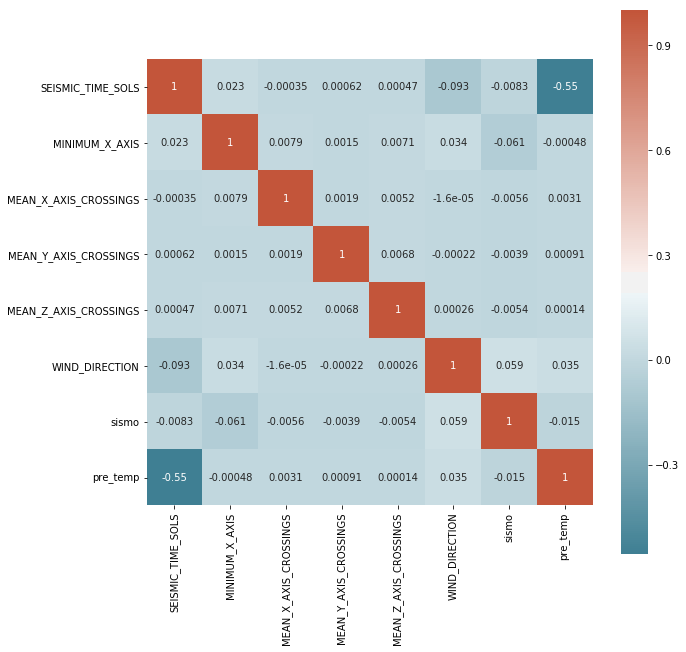

In [8]:
f, ax = plt.subplots(figsize=(10,10)) 
corr = core.corr()
sns.heatmap(corr,square=True ,cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax , annot = True) 

### Creamos el modelo K-Means, lo entrenamos y sacamos las etiquetas

In [9]:
# Entrenamos el modelo
model_kmeans = KMeans(n_clusters=5).fit(core)

# Sacamos los centroides
centroids = model_kmeans.cluster_centers_

# Sacamos los tags del dataset
labels = model_kmeans.predict(core)


In [10]:
# Asignamos las categorias al dataset original sin normalizar

fd["TAG"] = labels; 


In [11]:
fd.groupby("TAG").mean()

,ARCHIVED_RECORD_NUMBER,SEISMIC_TIME_SOLS,ORIGINAL_FILE_NUMBER,ORIGINAL_RECORD_NUMBER,DATA_ACQUISITION_SOL,DATA_ACQUISITION_HOUR,DATA_ACQUSITION_MINUTE,DATA_ACQUISITION_SECOND,MEDIAN_X_AXIS,FIRST_X_AXIS,...,RMS_Z_AXIS_X100,MEAN_X_AXIS_CROSSINGS,MEAN_Y_AXIS_CROSSINGS,MEAN_Z_AXIS_CROSSINGS,METEO_TIME_SOLS,WINDSPEED,PRESSURE,WIND_DIRECTION,AIR_TEMPERATURE,WIND_SEISMIC_INTERVAL
TAG,,,,,,,,,,,,,,,,,,,,,
0,178664.812223,787.919389,26981.726266,343.413664,9.235119,28.939295,29.503025,50.756143,1.956573,2.048862,...,221.648355,15.006837,15.017635,15.008803,343.808058,3.225674,9.090469,145.335402,180.090725,35999.288059
1,112113.705532,561.149056,55540.185161,207.860550,11.317324,30.012587,29.830739,50.823783,2.572044,-0.537595,...,1220.355084,14.809540,15.053660,14.820802,208.340110,3.493127,8.362955,124.224710,182.532395,67914.179861
2,148696.801980,685.238416,33277.603762,291.255050,13.361188,28.668515,29.497030,50.601188,24.787327,28.502574,...,4211.199010,14.885545,14.918218,14.877228,291.816580,13.708574,8.605389,168.082396,183.043406,11198.339406
3,36706.671695,244.948053,61274.786173,50.591284,12.367043,29.325638,29.449203,50.618323,2.189314,2.222619,...,279.235715,15.020858,15.025204,15.021973,51.112944,2.469480,7.536155,149.068728,210.612112,29158.532013
4,134773.341083,642.116958,31232.550125,252.947208,12.388917,29.273458,29.489875,50.666167,8.739667,9.940125,...,1489.640333,14.990125,15.007042,14.997625,253.469720,8.285987,8.712078,163.534633,180.462137,27945.505875


### Visualizamos los datos

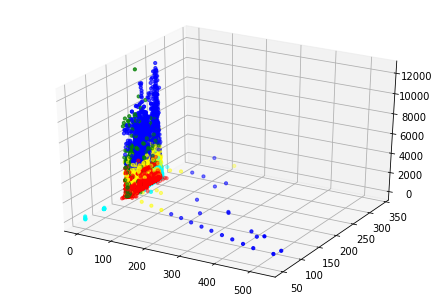

In [13]:
X = fd.copy()
colores=['red','green','blue','cyan','yellow']
asignar=[]
for row in labels:
    asignar.append(colores[row])
 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X.WINDSPEED, X.AIR_TEMPERATURE, X.RMS_Z_AXIS_X100, c=asignar,s=10)

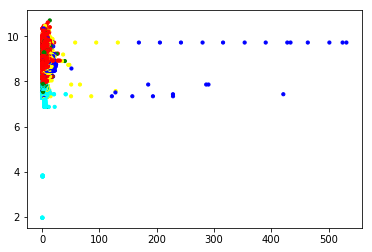

In [15]:
plt.scatter(X.WINDSPEED, X.PRESSURE, c=asignar, s=10)
plt.show()

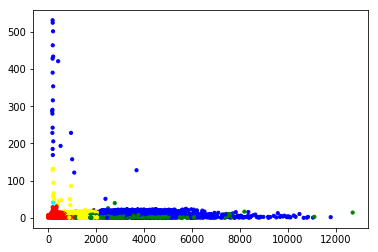

In [16]:
plt.scatter(X.RMS_X_AXIS_X100, X.WINDSPEED, c=asignar, s=10)
plt.show()